📂 正在读取文件: debug_U_rl1_U_rl1T.pt ...
✅ 成功加载。矩阵形状: (3840, 3840)

📊 数值分析:
 - Frobenius Norm (总体差异): 50.5964
 - Max Element Diff (最大单点差异): 0.9585

⚠️ 矩阵过大 (>3000)，跳过 SVD 分解以节省时间。


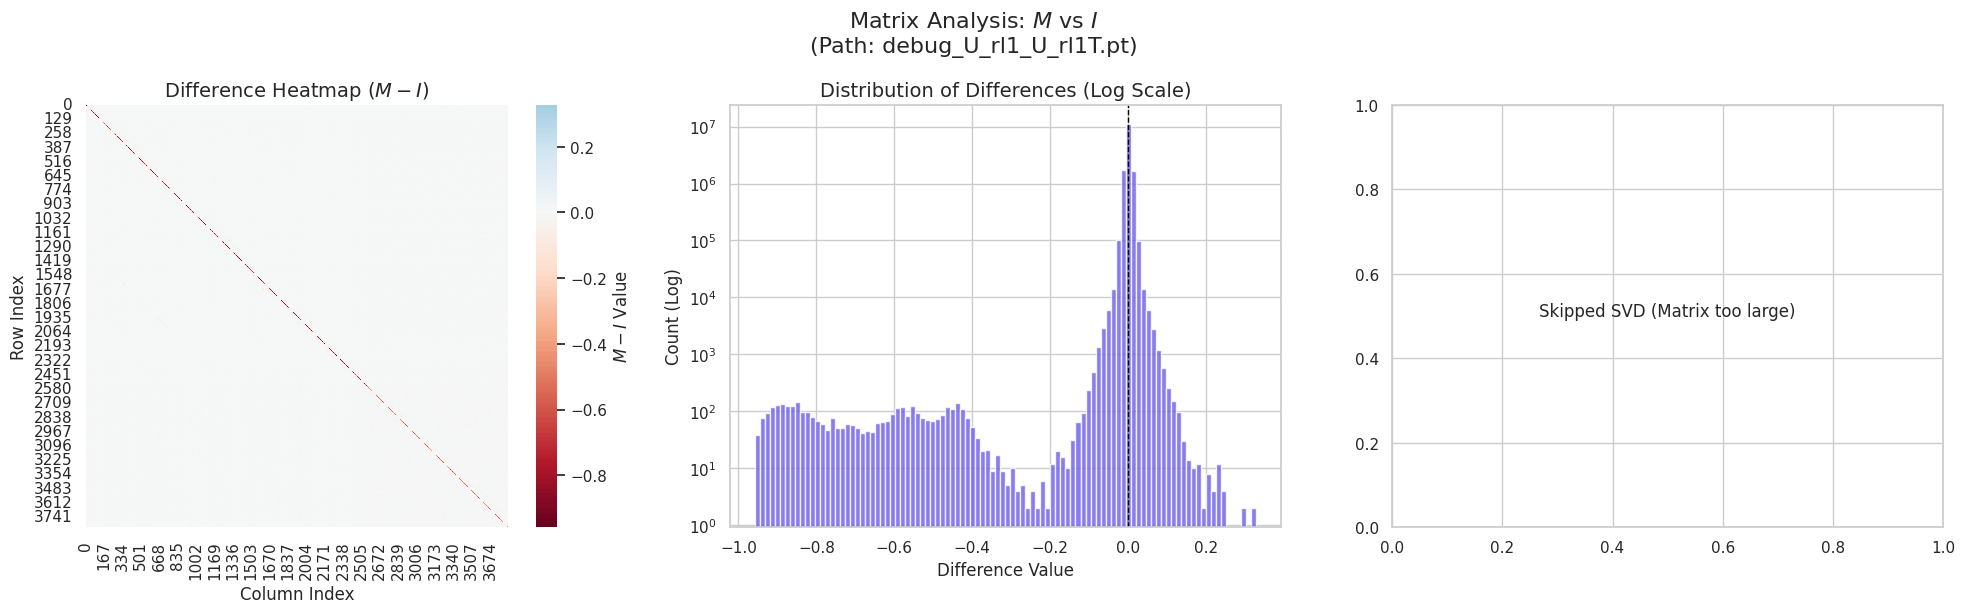

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.linalg import norm, svd
import os

# 让图片直接在 Notebook 中显示
%matplotlib inline

# 设置绘图风格
sns.set_theme(style="whitegrid")

def analyze_projection_matrix(file_path):
    """
    读取矩阵并分析它与单位矩阵 Identity Matrix 的差异。
    用于验证 U * U.T 是否为投影矩阵（Thin SVD）或单位阵（Full Rank Rotation）。
    """
    print(f"📂 正在读取文件: {file_path} ...")
    
    if not os.path.exists(file_path):
        print(f"❌ 错误: 找不到文件 {file_path}")
        print("请检查路径是否正确。")
        return

    # 1. 读取 Tensor
    try:
        # map_location='cpu' 保证即使原文件在 GPU 上也能读取
        M_tensor = torch.load(file_path, map_location='cpu')
    except Exception as e:
        print(f"❌ 读取失败: {e}")
        return

    # 转为 numpy
    if isinstance(M_tensor, torch.Tensor):
        M = M_tensor.detach().float().numpy()
    else:
        print("❌ 错误: 文件内容不是 PyTorch Tensor")
        return

    print(f"✅ 成功加载。矩阵形状: {M.shape}")

    # 检查是否为方阵，如果不是方阵，截取最大方阵部分
    if M.shape[0] != M.shape[1]:
        print("⚠️ 警告: 输入不是方阵。正在截取左上角方阵部分进行分析...")
        min_dim = min(M.shape)
        M = M[:min_dim, :min_dim]

    # 2. 计算差异矩阵 (Difference Matrix)
    n = M.shape[0]
    I = np.eye(n)
    Diff = M - I  # 核心：计算 M - I
    
    # 计算数值指标
    frob_norm = norm(Diff, 'fro')
    max_diff = np.max(np.abs(Diff))
    
    print(f"\n📊 数值分析:")
    print(f" - Frobenius Norm (总体差异): {frob_norm:.4f}")
    print(f" - Max Element Diff (最大单点差异): {max_diff:.4f}")

    # 3. 可视化
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    plt.suptitle(f"Matrix Analysis: $M$ vs $I$ \n(Path: {os.path.basename(file_path)})", fontsize=16)
    
    # --- 图 1: 热力图 (Difference Heatmap) ---
    # 使用 RdBu 色系：白=0，红=正，蓝=负
    # 如果是对角线变蓝 (-1)，说明该维度丢失了（Projection）
    sns.heatmap(Diff, ax=axes[0], cmap="RdBu", center=0, square=True, cbar_kws={'label': '$M - I$ Value'})
    axes[0].set_title("Difference Heatmap ($M - I$)", fontsize=14)
    axes[0].set_xlabel("Column Index")
    axes[0].set_ylabel("Row Index")
    
    # --- 图 2: 差异分布 (Histogram) ---
    # 观察差异是集中在 0 还是分布在 -1
    diff_vals = Diff.flatten()
    axes[1].hist(diff_vals, bins=100, color='#6c5ce7', alpha=0.8, log=True)
    axes[1].set_title("Distribution of Differences (Log Scale)", fontsize=14)
    axes[1].set_xlabel("Difference Value")
    axes[1].set_ylabel("Count (Log)")
    axes[1].axvline(0, color='black', linestyle='--', linewidth=1)

    # --- 图 3: 奇异值谱 (SVD Spectrum) ---
    # 检查秩 (Rank)。如果是单位阵，是一条 1.0 的直线。
    # 如果是投影矩阵，会呈阶梯状掉到 0。
    if n > 3000:
        print("\n⚠️ 矩阵过大 (>3000)，跳过 SVD 分解以节省时间。")
        axes[2].text(0.5, 0.5, "Skipped SVD (Matrix too large)", ha='center', fontsize=12)
    else:
        print("Wait computing SVD...")
        s = svd(M, compute_uv=False)
        axes[2].plot(s, linewidth=2, color='#e17055', label='Matrix $M$ Singular Values')
        axes[2].axhline(1.0, color='black', linestyle='--', alpha=0.5, label='Identity (Target)')
        axes[2].set_title("Singular Value Spectrum", fontsize=14)
        axes[2].set_xlabel("Index")
        axes[2].set_ylabel("Singular Value")
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# ==========================================
# 在这里指定你的文件路径并运行
# ==========================================
target_file = 'debug_U_rl1_U_rl1T.pt'

analyze_projection_matrix(target_file)

展示场景 A: 微小的 Rotation (应该很像单位阵)


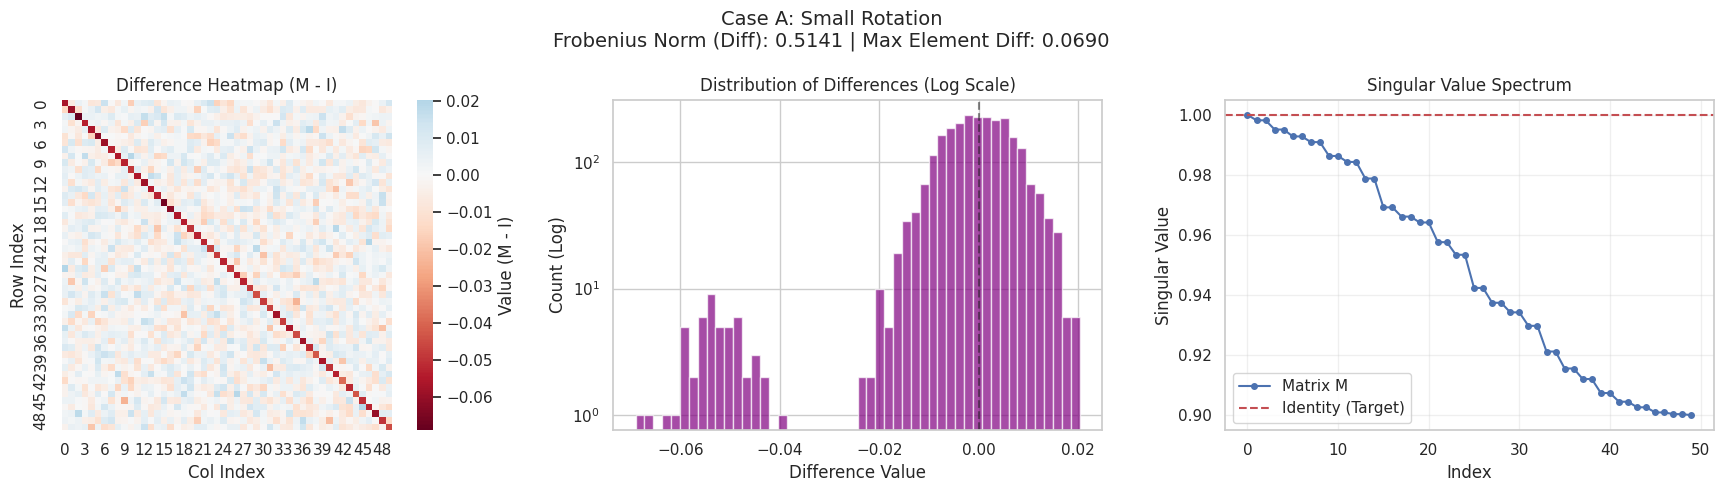


展示场景 B: 投影/秩坍缩 (后半段会和 I 差别巨大)


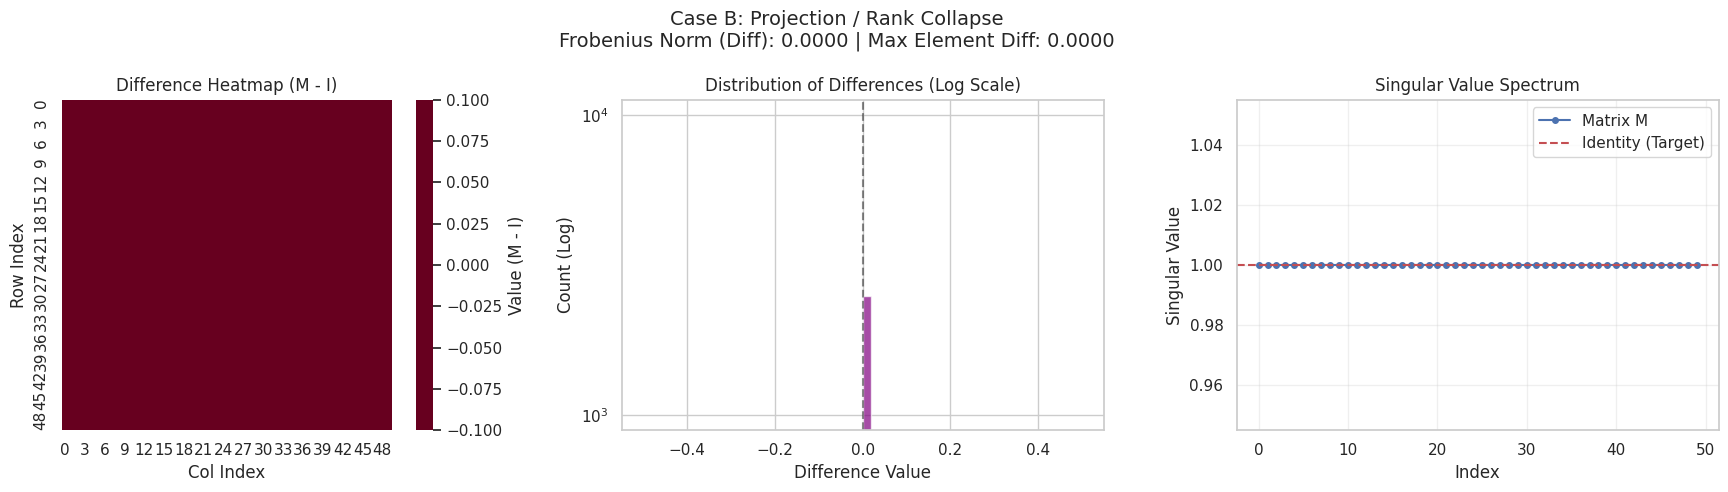

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.linalg import norm, svd

def visualize_matrix_diff(M, title="Matrix Analysis"):
    """
    可视化矩阵 M 与单位矩阵 I 的差异
    """
    n = M.shape[0]
    I = np.eye(n)
    Diff = M - I
    
    # 计算数值指标
    frob_norm = norm(Diff, 'fro') # Frobenius 范数 (总体差异)
    max_diff = np.max(np.abs(Diff)) # 最大单一元素差异
    
    # 设置画布
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    plt.suptitle(f"{title}\nFrobenius Norm (Diff): {frob_norm:.4f} | Max Element Diff: {max_diff:.4f}", fontsize=14)
    
    # --- 图 1: 差异热力图 (Heatmap) ---
    # 我们使用 'RdBu' 色系，0 是白色/浅色，红色为正偏差，蓝色为负偏差
    # 这样你可以一眼看出哪里不为 0
    sns.heatmap(Diff, ax=axes[0], cmap="RdBu", center=0, square=True, cbar_kws={'label': 'Value (M - I)'})
    axes[0].set_title("Difference Heatmap (M - I)")
    axes[0].set_xlabel("Col Index")
    axes[0].set_ylabel("Row Index")
    
    # --- 图 2: 差异值直方图 (Histogram) ---
    # 看看差异值的分布。如果是随机噪音，应该是正态分布；
    # 如果是对角线偏移，会有明显的双峰。
    diff_vals = Diff.flatten()
    axes[1].hist(diff_vals, bins=50, color='purple', alpha=0.7, log=True)
    axes[1].set_title("Distribution of Differences (Log Scale)")
    axes[1].set_xlabel("Difference Value")
    axes[1].set_ylabel("Count (Log)")
    axes[1].axvline(0, color='k', linestyle='--', alpha=0.5)

    # --- 图 3: 奇异值谱 (Singular Values) ---
    # 单位阵的所有奇异值都是 1。
    # 看看你的矩阵奇异值偏离 1 多远。
    s = svd(M, compute_uv=False)
    axes[2].plot(s, marker='o', linestyle='-', markersize=4, label='Matrix M')
    axes[2].axhline(1.0, color='r', linestyle='--', label='Identity (Target)')
    axes[2].set_title("Singular Value Spectrum")
    axes[2].set_xlabel("Index")
    axes[2].set_ylabel("Singular Value")
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# ==========================================
# 构造例子来测试
# ==========================================

# 1. 设置维度
N = 50 

# 场景 A: 一个几乎是单位阵的矩阵 (模拟微小的 Rotation)
# 生成一个随机正交矩阵，然后把它混合一点点单位阵
random_mat = np.random.randn(N, N)
Q, _ = np.linalg.qr(random_mat) # Q 是纯旋转
# 让它非常接近 I: I + 0.1 * (Q - I)
# 这代表模型只转了一点点
matrix_near_identity = np.eye(N) + 0.05 * (Q - np.eye(N))

# 场景 B: 一个投影矩阵 (模拟 Thin SVD 产生的 U U^T)
# 只有前 30 个维度是 1，后 20 个维度被砍掉了 (变成0)
matrix_projection = np.eye(N)
matrix_projection[30:, 30:] = 0 
# 再加一点旋转噪音，模拟真实情况
rot_noise = 0.01 * np.random.randn(N, N)
matrix_projection = matrix_projection + rot_noise

# ==========================================
# 运行可视化
# ==========================================

print("展示场景 A: 微小的 Rotation (应该很像单位阵)")
visualize_matrix_diff(matrix_near_identity, title="Case A: Small Rotation")

print("\n展示场景 B: 投影/秩坍缩 (后半段会和 I 差别巨大)")
visualize_matrix_diff(np.eye(N), title="Case B: Projection / Rank Collapse")